# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
# replace '?' with nan values
df = df.replace('?', np.nan)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


#### Get Dataframe stats

In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    4302 non-null    object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                89234 non-null   object
 11  medical_specialty         73961 non-null   object
 12  primary_diagnosis_code    143391 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [7]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
primary_diagnosis_code      object
other_diagnosis_codes       object
number_outpatient            int64
number_inpatient             int64
number_emergency             int64
num_lab_procedures           int64
number_diagnoses             int64
num_medications              int64
num_procedures               int64
ndc_code                    object
max_glu_serum               object
A1Cresult                   object
change                      object
readmitted                  object
dtype: object

In [8]:
print('Dataframe shape: ', df.shape)
# get dataframe nan values per column
df.isna().sum()

Dataframe shape:  (143424, 26)


encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes            0
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

In [9]:
# get dataframe zero values per column
df.isin([0]).sum()

encounter_id                     0
patient_nbr                      0
race                             0
gender                           0
age                              0
weight                           0
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                       0
medical_specialty                0
primary_diagnosis_code           0
other_diagnosis_codes            0
number_outpatient           120027
number_inpatient             96698
number_emergency            127444
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures               65788
ndc_code                         0
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: 
1. After analyzing the data, it can be concluded that the dataset is at line level. 
2. Apart from encounter_id and patient_nbr no "key fields" need to be considered.

In [10]:
# check for level of dataset
try:
    assert (len(df) > df.encounter_id.nunique()) == True
    print('**Could be LINE LEVEL Dataset**')
except:
    print('Not LINE LEVEL Dataset')

try:
    assert (len(df) == df.encounter_id.nunique()) == True
    print('**Could be ENCOUNTER LEVEL Dataset**')
except:
    print('Not ENCOUNTER LEVEL Dataset')

**Could be LINE LEVEL Dataset**
Not ENCOUNTER LEVEL Dataset


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: 
- a. Fields with high amount of missing data: 'race', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'ndc_code' && Fields with high amount of zero data: 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_procedures'
- b. Fields with numerical distribution: num_lab_procedures, num_medications, time_in_hospital, number_diagnosis
- c. Fields with high cardinality: admission_type_id (8), discharge_disposition_id (26), admission_source_id (17), payer_code (17), medical_specialty (72), primary_diagnosis_code (716), ndc_code (251)
- d. Age has normal distribution, Gender has uniform distribution

In [11]:
df.shape

(143424, 26)

In [12]:
# a: Missing/Zero Values
missing_values = df.isna().sum()
missing_value_index = missing_values[missing_values != 0].index
print('Missing Value Index: ', missing_value_index.tolist())
print('Missing Values:\n', missing_values[missing_value_index])

zero_values = df.isin([0]).sum()
zero_value_index = zero_values[zero_values != 0].index
print('Zero Value Index: ', zero_value_index.tolist())
print('Zero Values:\n', zero_values[zero_value_index])

Missing Value Index:  ['race', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'ndc_code']
Missing Values:
 race                        3309
weight                    139122
payer_code                 54190
medical_specialty          69463
primary_diagnosis_code        33
ndc_code                   23462
dtype: int64
Zero Value Index:  ['number_outpatient', 'number_inpatient', 'number_emergency', 'num_procedures']
Zero Values:
 number_outpatient    120027
number_inpatient      96698
number_emergency     127444
num_procedures        65788
dtype: int64


In [13]:
# b: Check for normal distribution in numerical fields
numerical_fields = ['weight', 'time_in_hospital', 'number_outpatient',
                    'number_inpatient','number_emergency', 'num_lab_procedures',
                    'number_diagnoses', 'num_medications', 'num_procedures']
print(df[numerical_fields].describe())

       time_in_hospital  number_outpatient  number_inpatient  \
count     143424.000000      143424.000000     143424.000000   
mean           4.490190           0.362429          0.600855   
std            2.999667           1.249295          1.207934   
min            1.000000           0.000000          0.000000   
25%            2.000000           0.000000          0.000000   
50%            4.000000           0.000000          0.000000   
75%            6.000000           0.000000          1.000000   
max           14.000000          42.000000         21.000000   

       number_emergency  num_lab_procedures  number_diagnoses  \
count     143424.000000       143424.000000     143424.000000   
mean           0.195086           43.255745          7.424434   
std            0.920410           19.657319          1.924872   
min            0.000000            1.000000          1.000000   
25%            0.000000           32.000000          6.000000   
50%            0.000000          

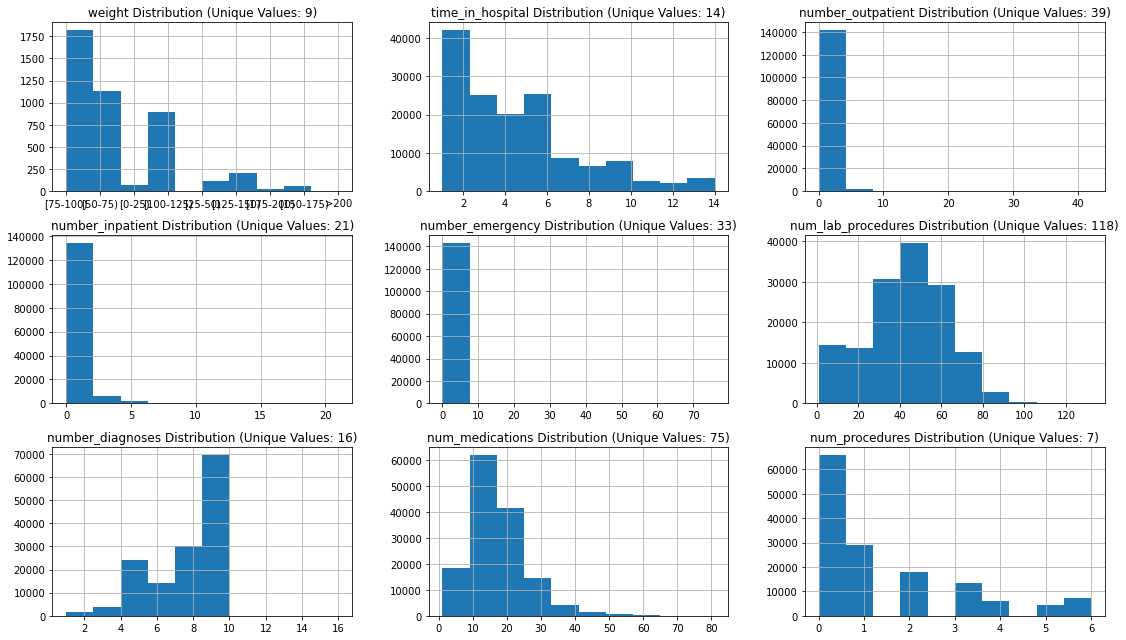

In [14]:
fig = plt.figure(figsize=(16, 9))
for index, col in enumerate(numerical_fields):
    plt.subplot(3, 3, index + 1)
    df[col].hist()
    plt.title(col + ' Distribution (Unique Values: {})'.format(df[col].nunique()))
plt.tight_layout()    

In [15]:
# c: Check for Cardinality
cardinal_fields = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                   'admission_source_id', 'payer_code', 'medical_specialty',
                   'primary_diagnosis_code', 'ndc_code', 'max_glu_serum',
                   'A1Cresult', 'change']
for col in cardinal_fields:
    print('Cardinality of {} is {}'.format(col, df[col].nunique()))

Cardinality of race is 5
Cardinality of gender is 3
Cardinality of admission_type_id is 8
Cardinality of discharge_disposition_id is 26
Cardinality of admission_source_id is 17
Cardinality of payer_code is 17
Cardinality of medical_specialty is 72
Cardinality of primary_diagnosis_code is 716
Cardinality of ndc_code is 251
Cardinality of max_glu_serum is 4
Cardinality of A1Cresult is 4
Cardinality of change is 2


A couple of features have really high cardinality. 
1. primary_diagnosis_code refers to illness of the patient. As it is patient dependent, it has high cardinality.
2. medical_speciality refers to The above field refers to the medical speciality that the patient may be referred to. Since it's a patient dependent field and a patient could have multiple disease diagnosis, this field has high cardinality.

Similarly, ndc_code, admission_source_id and discharge_disposition_id are all related to patient and its value dependent upon the illness, number of consultations and the physician. Therefore they are bound to have high cardinality. Moreover, if the datasize is increased by including wider population, the cardinality of these field would be even higher.

Text(0.5, 1.0, 'Age Distribution')

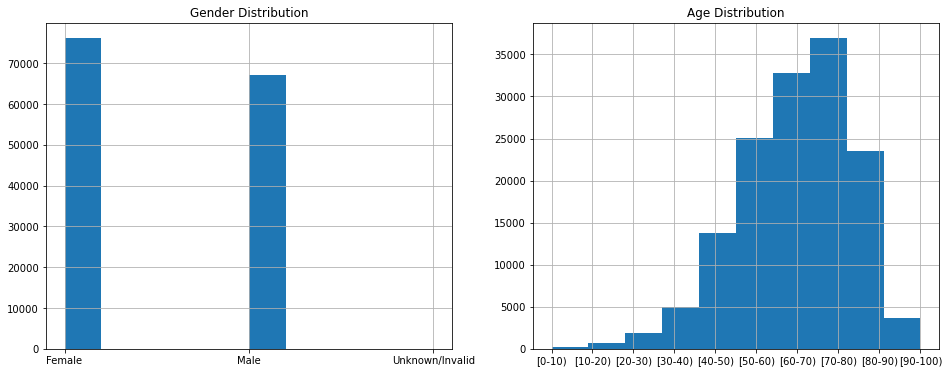

In [16]:
# d: demographic distribution
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
df.gender.hist()
plt.title('Gender Distribution')

plt.subplot(1, 2, 2)
df.age.hist()
plt.title('Age Distribution')

Gender distribution: The dataset contains higher number of females than men. For unbiased training, the gender distribution should be uniform. For the given dataset, there is a small possibility that the model prefers female over male patients.

Age distribution: The dataset is right skewed with median value being around 60-80 age group. There are chances that the predictive ability of the model outside 60-90 age range may not be as good. Moreover, the patients below the age of 40 and above the age of 90 are highly under-represented. This would also mean that model might never select patients in those age groups.

In [17]:
# ######NOTE: The visualization will only display in Chrome browser. ########
# import tensorflow_data_validation as tfdv

# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [18]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [19]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [20]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [21]:
print("Unique ndc codes in patient data:{}\
       \nUnique ndc codes in code list:{}\
       \nGeneric names in code list:{}"
      .format(df.ndc_code.nunique(), ndc_code_df.NDC_Code.nunique(),
              ndc_code_df["Non-proprietary Name"].nunique()))

Unique ndc codes in patient data:251       
Unique ndc codes in code list:267       
Generic names in code list:24


In [22]:
ndc_code_df.columns.values

array(['NDC_Code', 'Proprietary Name', 'Non-proprietary Name',
       'Dosage Form', 'Route Name', 'Company Name', 'Product Type'],
      dtype=object)

In [23]:
from student_utils import reduce_dimension_ndc

In [24]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [25]:
reduce_dim_df.shape

(120020, 27)

In [26]:
reduce_dim_df.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R
5,77076,92519352,AfricanAmerican,Male,[50-60),NaN,1,1,7,4,NaN,NaN,410,411|414,0,0,0,45,8,17,4,68071-1701,None,None,Ch,<30,Novolin R
6,150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,NaN,NaN,410,427|428,0,0,0,66,7,19,1,68071-1701,None,None,Ch,NO,Novolin R
7,150048,21239181,NaN,Male,[60-70),NaN,2,1,4,2,NaN,NaN,572,456|427,0,0,0,36,6,11,2,68071-1701,None,None,Ch,NO,Novolin R
8,248916,115196778,Caucasian,Female,[50-60),NaN,1,1,1,2,NaN,Surgery-General,996,585|250.01,0,0,0,25,3,11,2,68071-1701,None,None,No,>30,Novolin R
9,325866,98427861,Caucasian,Female,[70-80),NaN,3,1,2,3,NaN,NaN,174,135|250,0,0,0,33,5,8,1,68071-1701,None,None,No,NO,Novolin R


In [27]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print(df['ndc_code'].nunique(), reduce_dim_df['generic_drug_name'].nunique())

251 36


In [28]:
reduce_dim_df.shape[0], reduce_dim_df.encounter_id.nunique(), reduce_dim_df.patient_nbr.nunique()

(120020, 78304, 56133)

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [29]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [30]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


In [31]:
print(len(df), len(first_encounter_df))
first_encounter_df

143424 56133


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
22979,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,398,427|38,0,0,0,68,8,28,2,0049-4110,None,None,Ch,NO,Glucotrol
3,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
22978,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glucotrol
4,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R
26409,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,NaN,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Afrezza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46783,443842016,183087545,Caucasian,Female,[70-80),NaN,1,1,7,9,NaN,NaN,574,574|250.02,0,0,0,50,9,33,2,47918-902,None,>7,Ch,>30,Afrezza
59773,443842022,188574944,Other,Female,[40-50),NaN,1,1,7,14,MD,NaN,592,599|518,0,0,1,73,9,26,6,0049-0178,None,>8,Ch,>30,Glucotrol XL
46784,443842070,140199494,Other,Female,[60-70),NaN,1,1,7,2,MD,NaN,996,585|403,1,1,1,46,9,17,6,47918-902,None,None,No,>30,Afrezza
20766,443842136,181593374,Caucasian,Female,[70-80),NaN,1,1,7,5,NaN,NaN,491,518|511,0,1,0,21,9,16,1,68071-1701,None,None,No,NO,Novolin R


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [32]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [33]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [34]:
print(len(agg_drug_df), agg_drug_df['patient_nbr'].nunique(), agg_drug_df['encounter_id'].nunique())

602 602 602


In [35]:
len(ndc_col_list)

24

In [36]:
agg_drug_df.shape

(602, 51)

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response:
1. payer_code: This field is irrelevant for designing a model. This category is basically you pays the bill for the treatment. It has no intrinsic value in determining if the patient needs more or less hospitalization time or whether the drug will work or not. DO NOT INCLUDE
2. weight: This field is also irrelevant for designing a model. A tall slim person may have same height as short fat person. So the "weight" parameter by itself is immaterial and should be neglected here.

Moreover, both of them have high % of Null values and hence their inclusion is immaterial


Text(0.5, 1.0, 'Weight Distribution')

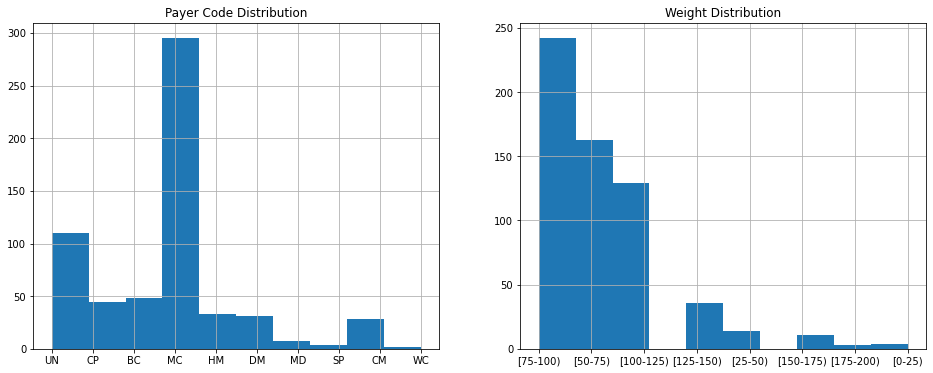

In [37]:
# visualizing additional fields
fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
agg_drug_df.payer_code.hist()
plt.title('Payer Code Distribution')

plt.subplot(1, 2, 2)
agg_drug_df.weight.hist()
plt.title('Weight Distribution')

In [38]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ['admission_type_id', 'discharge_disposition_id', 'primary_diagnosis_code',
                                'other_diagnosis_codes', 'ndc_code', 'readmitted', 'max_glu_serum', 'A1Cresult',
                                'change'] + required_demo_col_list + ndc_col_list

student_numerical_col_list = ['num_lab_procedures', 'num_medications', 'number_diagnoses']

PREDICTOR_FIELD = 'time_in_hospital'  # estimated hospitalization time

In [39]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [40]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list,
                                             student_numerical_col_list, PREDICTOR_FIELD)

In [41]:
selected_features_df.head()

,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,primary_diagnosis_code,other_diagnosis_codes,ndc_code,readmitted,max_glu_serum,A1Cresult,change,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glynase,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Nateglinide,Novolin_R,Pioglitazone,Prandin,Repaglinide,Riomet,Riomet_Er,num_lab_procedures,num_medications,number_diagnoses
0,100654011,10,3,3,715,402|428,68071-1701,<30,None,None,Ch,Caucasian,Female,[70-80),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,65,28,9
1,58682736,6,1,11,250.2,780|403,68071-1701,NO,None,None,No,Caucasian,Male,[80-90),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,73,16,9
2,69250302,2,1,1,414,411|401,0781-5422,>30,None,None,No,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,58,12,9
3,30950811,2,3,1,196,199|250,0093-8342,>30,None,None,No,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,11,7
4,58763808,10,1,3,250.4,403|276,0591-0460,<30,None,None,No,Caucasian,Female,[70-80),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,20,9


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [42]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [43]:
processed_df.head()

,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,primary_diagnosis_code,other_diagnosis_codes,ndc_code,readmitted,max_glu_serum,A1Cresult,change,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glynase,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Nateglinide,Novolin_R,Pioglitazone,Prandin,Repaglinide,Riomet,Riomet_Er,num_lab_procedures,num_medications,number_diagnoses
0,100654011,10.0,3,3,715,402|428,68071-1701,<30,None,None,Ch,Caucasian,Female,[70-80),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,65,28,9
1,58682736,6.0,1,11,250.2,780|403,68071-1701,NO,None,None,No,Caucasian,Male,[80-90),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,73,16,9
2,69250302,2.0,1,1,414,411|401,0781-5422,>30,None,None,No,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,58,12,9
3,30950811,2.0,3,1,196,199|250,0093-8342,>30,None,None,No,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,11,7
4,58763808,10.0,1,3,250.4,403|276,0591-0460,<30,None,None,No,Caucasian,Female,[70-80),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,20,9


In [44]:
processed_df.shape

(602, 41)

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [45]:
from student_utils import patient_dataset_splitter

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Total number of unique patients in train =  361
Total number of unique patients in validation =  121
Total number of unique patients in test =  120
Training partition has a shape =  (361, 41)
Validation partition has a shape =  (121, 41)
Test partition has a shape =  (120, 41)


In [46]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [47]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      45
2.0      96
3.0     128
4.0     100
5.0      57
6.0      48
7.0      39
8.0      31
9.0      18
10.0     10
11.0      8
12.0     10
13.0      9
14.0      3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


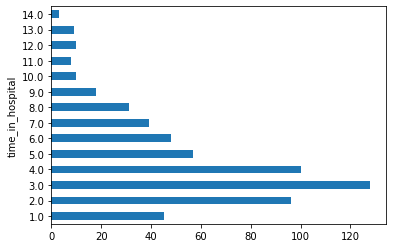

In [48]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     28
2.0     60
3.0     69
4.0     56
5.0     36
6.0     29
7.0     28
8.0     19
9.0     12
10.0     4
11.0     3
12.0     7
13.0     7
14.0     3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


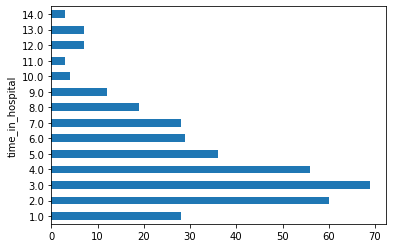

In [49]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     10
2.0     15
3.0     27
4.0     24
5.0     13
6.0      7
7.0      6
8.0      6
9.0      2
10.0     3
11.0     4
12.0     2
13.0     1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


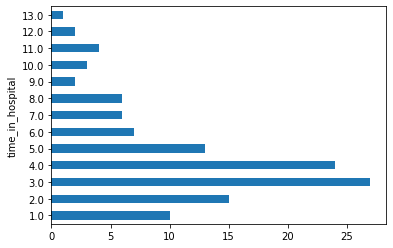

In [50]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    305
Male      297
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


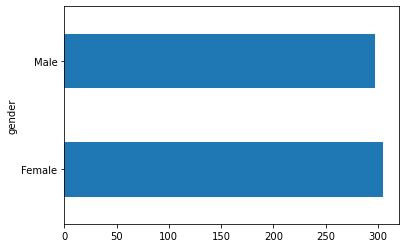

In [51]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    185
Male      176
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


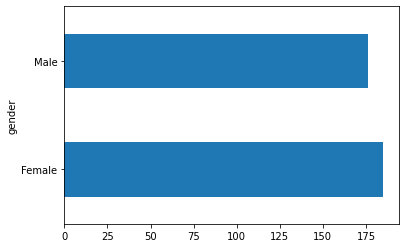

In [52]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    61
Male      59
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


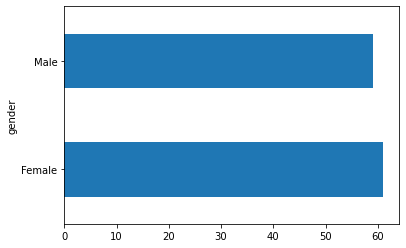

In [53]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [54]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [55]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [56]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [57]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 5 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 10 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 126 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 279 in other_diagnosis_codes is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/other_diagnosis_codes_vocab.txt.
INFO:tensorflow:vocabulary_size = 102 in ndc_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/ndc_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.tx

In [58]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=5, num_oov_buckets=0, dtype=tf.string, default_value=-1), dimension=10, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7ffaa4ead090>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)
tf.Tensor(
[[-0.49707502 -0.31461337 -0.08529861 ... -0.05314555 -0.40140384
  -0.05315612]
 [-0.49707502 -0.31461337 -0.08529861 ... -0.05314555 -0.40140384
  -0.05315612]
 [-0.49707502 -0.31461337 -0.08529861 ... -0.05314555 -0.40140384
  -0.05315612]
 ...
 [-0.34946713 -0.01580229 -0.21197663 ...  0.14361389 -0.47297046
  -0.3210568 ]
 [-0.34946713 -0.01580229 -0.21197663 ...  0.14361389 -0.47297046
  -0.3210568 ]
 [-0.49707502 -0.31461337 -0.08529861 ... -0.05314555 -0.40140384
  -0.05315612]], shape=(128, 10), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [59]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [60]:
student_numerical_col_list

['num_lab_procedures', 'num_medications', 'number_diagnoses']

In [61]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [62]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [63]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7ffaaa751320>, mean=52.3185595567867, std=19.639696595512984))

tf.Tensor(
[[ 1.9473684 ]
 [-0.05263158]
 [ 0.21052632]
 [ 0.8947368 ]
 [ 1.        ]
 [ 0.94736844]
 [-1.0526316 ]
 [ 1.0526316 ]
 [-0.05263158]
 [-0.68421054]
 [-0.7368421 ]
 [-0.68421054]
 [-2.5263157 ]
 [-1.0526316 ]
 [ 0.8947368 ]
 [ 1.4736842 ]
 [ 0.7894737 ]
 [-0.8947368 ]
 [-1.4210526 ]
 [-1.1578947 ]
 [ 1.1578947 ]
 [-0.2631579 ]
 [-0.36842105]
 [-0.15789473]
 [ 0.10526316]
 [-0.05263158]
 [-0.8947368 ]
 [ 0.47368422]
 [-1.5263158 ]
 [ 0.7368421 ]
 [-1.        ]
 [-1.2631578 ]
 [-1.6842105 ]
 [ 1.2105263 ]
 [ 0.84210527]
 [ 0.15789473]
 [ 0.8947368 ]
 [ 0.31578946]
 [-2.5263157 ]
 [-1.0526316 ]
 [-0.94736844]
 [-1.2631578 ]
 [-2.4736843 ]
 [ 0.10526316]
 [ 0.10526316]
 [ 1.2631578 ]
 [ 1.0526316 ]
 [ 0.31578946]
 [ 0.1578947

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [64]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [67]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                              scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=400)
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [68]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,
                                               claim_feature_layer,  epochs=1000)

Train for 3 steps, validate for 1 steps
Epoch 1/1000
3/3 [==============================] - 12s 4s/step - loss: 32.7737 - mse: 33.1666 - val_loss: 47.3800 - val_mse: 47.4411
Epoch 2/1000
3/3 [==============================] - 0s 97ms/step - loss: 31.9379 - mse: 29.8063 - val_loss: 44.4354 - val_mse: 44.3310
Epoch 3/1000
3/3 [==============================] - 0s 96ms/step - loss: 61.7068 - mse: 61.3680 - val_loss: 9.2710 - val_mse: 9.1905
Epoch 4/1000
3/3 [==============================] - 0s 98ms/step - loss: 36.8809 - mse: 37.8365 - val_loss: 13.7316 - val_mse: 13.6972
Epoch 5/1000
3/3 [==============================] - 0s 96ms/step - loss: 34.9350 - mse: 36.2202 - val_loss: 11.2262 - val_mse: 11.1888
Epoch 6/1000
3/3 [==============================] - 0s 96ms/step - loss: 49.7199 - mse: 48.3132 - val_loss: 8.8126 - val_mse: 8.5134
Epoch 7/1000
3/3 [==============================] - 0s 97ms/step - loss: 23.2579 - mse: 23.4676 - val_loss: 6.4556 - val_mse: 6.3415
Epoch 8/1000
3/3 [====

3/3 [==============================] - 0s 99ms/step - loss: 23.5444 - mse: 23.8595 - val_loss: 10.3489 - val_mse: 10.6555
Epoch 122/1000
3/3 [==============================] - 0s 100ms/step - loss: 21.5937 - mse: 21.8310 - val_loss: 6.5636 - val_mse: 6.2119
Epoch 123/1000
3/3 [==============================] - 0s 97ms/step - loss: 12.7205 - mse: 11.7708 - val_loss: 22.2249 - val_mse: 22.2168
Epoch 124/1000
3/3 [==============================] - 0s 98ms/step - loss: 44.8999 - mse: 45.9412 - val_loss: 7.5979 - val_mse: 5.9971
Epoch 125/1000
3/3 [==============================] - 0s 97ms/step - loss: 15.0604 - mse: 14.1231 - val_loss: 7.0078 - val_mse: 6.1792
Epoch 126/1000
3/3 [==============================] - 0s 97ms/step - loss: 14.9149 - mse: 14.6722 - val_loss: 18.3830 - val_mse: 18.4785
Epoch 127/1000
3/3 [==============================] - 0s 98ms/step - loss: 21.6735 - mse: 21.6655 - val_loss: 6.7319 - val_mse: 6.7681
Epoch 128/1000
3/3 [==============================] - 0s 100ms/

3/3 [==============================] - 0s 96ms/step - loss: 12.1878 - mse: 12.1463 - val_loss: 8.9667 - val_mse: 7.9404
Epoch 242/1000
3/3 [==============================] - 0s 98ms/step - loss: 8.2022 - mse: 7.0945 - val_loss: 14.8984 - val_mse: 14.3570
Epoch 243/1000
3/3 [==============================] - 0s 97ms/step - loss: 8.1022 - mse: 6.1574 - val_loss: 16.9757 - val_mse: 17.4284
Epoch 244/1000
3/3 [==============================] - 0s 94ms/step - loss: 17.2343 - mse: 15.9889 - val_loss: 51.7778 - val_mse: 53.4178
Epoch 245/1000
3/3 [==============================] - 0s 98ms/step - loss: 9.6674 - mse: 8.6965 - val_loss: 4.4882 - val_mse: 5.5306
Epoch 246/1000
3/3 [==============================] - 0s 98ms/step - loss: 15.3960 - mse: 14.0925 - val_loss: 6.9142 - val_mse: 5.1994
Epoch 247/1000
3/3 [==============================] - 0s 95ms/step - loss: 13.2786 - mse: 12.1996 - val_loss: 15.4032 - val_mse: 14.9912
Epoch 248/1000
3/3 [==============================] - 0s 98ms/step -

Epoch 362/1000
3/3 [==============================] - 0s 100ms/step - loss: 8.6328 - mse: 7.9305 - val_loss: 47.5108 - val_mse: 42.9270
Epoch 363/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.8012 - mse: 2.9185 - val_loss: 10.5015 - val_mse: 9.3750
Epoch 364/1000
3/3 [==============================] - 0s 99ms/step - loss: 3.1793 - mse: 1.9023 - val_loss: 10.6284 - val_mse: 8.3494
Epoch 365/1000
3/3 [==============================] - 0s 99ms/step - loss: 11.8515 - mse: 10.4703 - val_loss: 22.6852 - val_mse: 24.4605
Epoch 366/1000
3/3 [==============================] - 0s 100ms/step - loss: 13.4970 - mse: 13.4051 - val_loss: 15.5606 - val_mse: 13.8563
Epoch 367/1000
3/3 [==============================] - 0s 103ms/step - loss: 6.6280 - mse: 5.2805 - val_loss: 8.3945 - val_mse: 9.1091
Epoch 368/1000
3/3 [==============================] - 0s 98ms/step - loss: 4.6336 - mse: 2.8541 - val_loss: 7.7563 - val_mse: 5.7416
Epoch 369/1000
3/3 [==============================] - 

Epoch 423/1000
3/3 [==============================] - 0s 100ms/step - loss: 8.0788 - mse: 6.4810 - val_loss: 12.3529 - val_mse: 12.8524
Epoch 424/1000
3/3 [==============================] - 0s 98ms/step - loss: 10.1647 - mse: 9.0991 - val_loss: 9.9966 - val_mse: 6.1331
Epoch 425/1000
3/3 [==============================] - 0s 100ms/step - loss: 5.6746 - mse: 4.4761 - val_loss: 9.6878 - val_mse: 9.3104
Epoch 426/1000
3/3 [==============================] - 0s 102ms/step - loss: 4.6579 - mse: 4.3658 - val_loss: 7.7410 - val_mse: 7.0379
Epoch 427/1000
3/3 [==============================] - 0s 100ms/step - loss: 12.9099 - mse: 12.0608 - val_loss: 9.3900 - val_mse: 6.5545
Epoch 428/1000
3/3 [==============================] - 0s 98ms/step - loss: 4.5889 - mse: 3.2986 - val_loss: 14.4726 - val_mse: 13.0509
Epoch 429/1000
3/3 [==============================] - 0s 100ms/step - loss: 11.0640 - mse: 8.0746 - val_loss: 19.8381 - val_mse: 16.8653
Epoch 430/1000
3/3 [==============================] - 

Epoch 484/1000
3/3 [==============================] - 0s 108ms/step - loss: 10.4429 - mse: 9.5908 - val_loss: 5.7152 - val_mse: 5.3379
Epoch 485/1000
3/3 [==============================] - 0s 101ms/step - loss: 3.2648 - mse: 2.2848 - val_loss: 5.7008 - val_mse: 5.3079
Epoch 486/1000
3/3 [==============================] - 0s 100ms/step - loss: 4.1367 - mse: 3.4251 - val_loss: 15.5009 - val_mse: 16.4784
Epoch 487/1000
3/3 [==============================] - 0s 99ms/step - loss: 5.1352 - mse: 4.6094 - val_loss: 9.1392 - val_mse: 6.2013
Epoch 488/1000
3/3 [==============================] - 0s 100ms/step - loss: 4.3059 - mse: 4.1126 - val_loss: 9.8043 - val_mse: 9.3653
Epoch 489/1000
3/3 [==============================] - 0s 99ms/step - loss: 9.0389 - mse: 8.8290 - val_loss: 11.9954 - val_mse: 10.0505
Epoch 490/1000
3/3 [==============================] - 0s 99ms/step - loss: 5.3383 - mse: 5.1688 - val_loss: 7.4773 - val_mse: 6.5085
Epoch 491/1000
3/3 [==============================] - 0s 97m

Epoch 545/1000
3/3 [==============================] - 0s 98ms/step - loss: 4.3532 - mse: 2.7147 - val_loss: 7.3040 - val_mse: 5.2758
Epoch 546/1000
3/3 [==============================] - 0s 100ms/step - loss: 5.6398 - mse: 5.8843 - val_loss: 6.8597 - val_mse: 5.9760
Epoch 547/1000
3/3 [==============================] - 0s 100ms/step - loss: 4.0538 - mse: 2.7896 - val_loss: 6.4040 - val_mse: 6.2387
Epoch 548/1000
3/3 [==============================] - 0s 96ms/step - loss: 3.6105 - mse: 3.2979 - val_loss: 8.4376 - val_mse: 6.9310
Epoch 549/1000
3/3 [==============================] - 0s 98ms/step - loss: 2.6202 - mse: 2.2424 - val_loss: 9.9586 - val_mse: 7.6083
Epoch 550/1000
3/3 [==============================] - 0s 99ms/step - loss: 4.9165 - mse: 3.6389 - val_loss: 7.5550 - val_mse: 5.5305
Epoch 551/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.7648 - mse: 3.5760 - val_loss: 13.7976 - val_mse: 16.5364
Epoch 552/1000
3/3 [==============================] - 0s 99ms/ste

3/3 [==============================] - 0s 96ms/step - loss: 6.0597 - mse: 6.0204 - val_loss: 8.7106 - val_mse: 5.8378
Epoch 668/1000
3/3 [==============================] - 0s 94ms/step - loss: 4.4701 - mse: 3.4596 - val_loss: 8.1838 - val_mse: 7.3452
Epoch 669/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.7662 - mse: 3.3960 - val_loss: 7.4146 - val_mse: 6.7946
Epoch 670/1000
3/3 [==============================] - 0s 95ms/step - loss: 7.2515 - mse: 4.0600 - val_loss: 6.9333 - val_mse: 5.6951
Epoch 671/1000
3/3 [==============================] - 0s 110ms/step - loss: 2.3295 - mse: 0.9953 - val_loss: 15.3325 - val_mse: 16.3313
Epoch 672/1000
3/3 [==============================] - 0s 101ms/step - loss: 4.4856 - mse: 2.5785 - val_loss: 8.7480 - val_mse: 7.1523
Epoch 673/1000
3/3 [==============================] - 0s 94ms/step - loss: 7.7211 - mse: 6.0742 - val_loss: 16.6830 - val_mse: 16.2114
Epoch 674/1000
3/3 [==============================] - 0s 95ms/step - loss: 3.2

3/3 [==============================] - 0s 95ms/step - loss: 5.0075 - mse: 2.9523 - val_loss: 8.1420 - val_mse: 6.5938
Epoch 790/1000
3/3 [==============================] - 0s 95ms/step - loss: 4.7044 - mse: 4.1637 - val_loss: 8.7360 - val_mse: 7.0349
Epoch 791/1000
3/3 [==============================] - 0s 96ms/step - loss: 4.3971 - mse: 2.5673 - val_loss: 7.1407 - val_mse: 6.0406
Epoch 792/1000
3/3 [==============================] - 0s 94ms/step - loss: 3.1734 - mse: 3.2782 - val_loss: 8.5800 - val_mse: 7.1396
Epoch 793/1000
3/3 [==============================] - 0s 94ms/step - loss: 6.6918 - mse: 5.6301 - val_loss: 10.2966 - val_mse: 8.7689
Epoch 794/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.7024 - mse: 4.1047 - val_loss: 6.6138 - val_mse: 7.9168
Epoch 795/1000
3/3 [==============================] - 0s 95ms/step - loss: 2.4076 - mse: 1.7510 - val_loss: 9.0898 - val_mse: 5.7644
Epoch 796/1000
3/3 [==============================] - 0s 96ms/step - loss: 5.8565 -

3/3 [==============================] - 0s 96ms/step - loss: 5.8901 - mse: 4.2818 - val_loss: 7.3078 - val_mse: 6.0170
Epoch 912/1000
3/3 [==============================] - 0s 95ms/step - loss: 5.2037 - mse: 2.9295 - val_loss: 13.5235 - val_mse: 10.9845
Epoch 913/1000
3/3 [==============================] - 0s 94ms/step - loss: 3.1288 - mse: 2.9559 - val_loss: 7.9994 - val_mse: 5.7889
Epoch 914/1000
3/3 [==============================] - 0s 94ms/step - loss: 3.7725 - mse: 1.4406 - val_loss: 7.6304 - val_mse: 6.6898
Epoch 915/1000
3/3 [==============================] - 0s 95ms/step - loss: 3.8641 - mse: 2.4384 - val_loss: 10.1739 - val_mse: 8.0200
Epoch 916/1000
3/3 [==============================] - 0s 96ms/step - loss: 5.2228 - mse: 4.2241 - val_loss: 3.4397 - val_mse: 5.3640
Epoch 917/1000
3/3 [==============================] - 0s 94ms/step - loss: 2.1830 - mse: 1.0295 - val_loss: 5.8505 - val_mse: 5.6479
Epoch 918/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.9662

In [69]:
diabetes_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  6240      
_________________________________________________________________
dense_2 (Dense)              multiple                  54600     
_________________________________________________________________
dense_3 (Dense)              multiple                  11325     
_________________________________________________________________
dense_variational_1 (DenseVa multiple                  456       
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 72,621
Trainable params: 72,621
Non-trainable params: 0
_________________________________________________________________


In [70]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

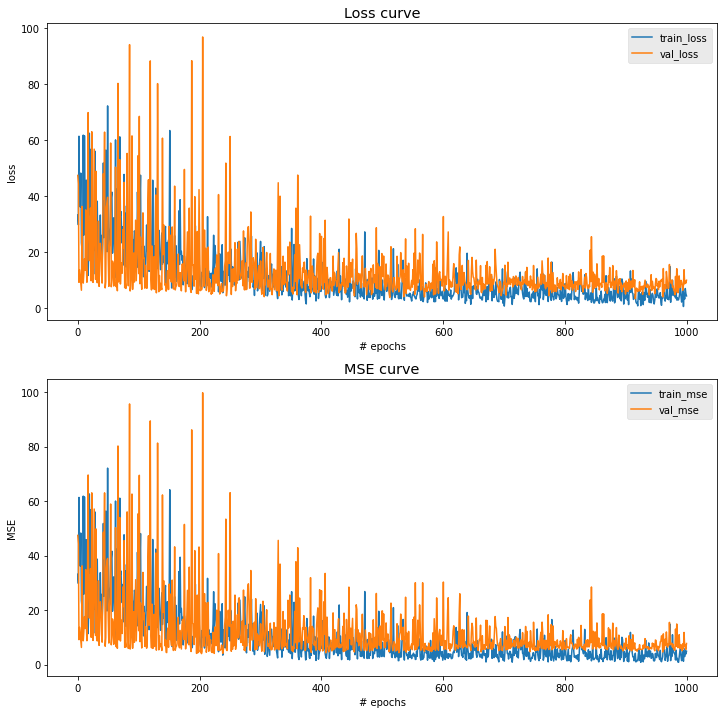

In [71]:
def plot_history(history):
    
    fig, axs = plt.subplots(2, 1, figsize = (12, 12))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["mse"], label = 'train_mse')
    axs[1].plot(np.arange(N), history.history["val_mse"], label = 'val_mse')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('MSE')
    axs[1].set_title('MSE curve')
    axs[1].legend()
    
plot_history(history)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [72]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [73]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [74]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [75]:
prob_output_df.head(20)

,pred,actual_value,pred_mean,pred_std
0,5.700900,4.0,5.601608,0.692859
1,4.714905,3.0,4.294679,0.690719
2,0.440147,8.0,7.572061,0.694950
3,5.486260,1.0,2.746539,0.688472
4,3.353778,2.0,3.540328,0.690086
5,6.786156,11.0,7.146473,0.694607
6,4.466994,6.0,2.639270,0.688672
7,4.358155,3.0,2.780405,0.689190
8,3.116552,4.0,3.988500,0.690615
9,4.403523,2.0,2.090507,0.690842


In [76]:
prob_output_df.actual_value.describe().transpose()

count    120.000000
mean       4.525000
std        2.746923
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       13.000000
Name: actual_value, dtype: float64

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [77]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [78]:
def add_pred_to_test(test_df, pred_np, demo_col_list, thresh=5):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=thresh else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'], thresh=5)

In [79]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,68172498,Male,Caucasian,4.0,1,0
1,60001884,Male,Caucasian,3.0,0,0
2,72468270,Male,Caucasian,8.0,1,1
3,91231434,Male,Caucasian,1.0,0,0
4,84774825,Female,Caucasian,2.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [80]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, auc, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve

In [81]:
# AUC, F1, precision and recall
# Summary

y_true = pred_test_df['label_value'].values
y_pred = pred_test_df['score'].values

# Summary
print("Accuracy Score : {:.4f}\n".format(accuracy_score(y_true, y_pred)))
print("Area under the Curve : {:.4f}\n".format(roc_auc_score(y_true, y_pred)))
print("Weighted F1 Score : {:.4f}\n".format(f1_score(y_true, y_pred, average='weighted')))
print("Classification Report : \n", classification_report(y_pred=y_pred, y_true=y_true))

Accuracy Score : 0.7250

Area under the Curve : 0.7063

Weighted F1 Score : 0.7256

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.78      0.78        76
           1       0.62      0.64      0.63        44

    accuracy                           0.73       120
   macro avg       0.70      0.71      0.71       120
weighted avg       0.73      0.72      0.73       120



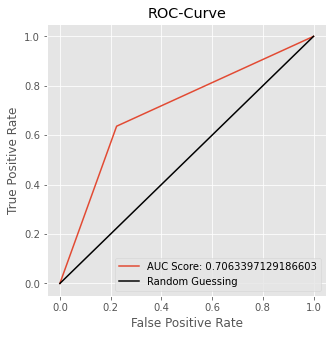

In [82]:
def plot_roc_curve(ground_truth, probability):
    ## YOUR CODE HERE
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    plt.figure(figsize = (5, 5))
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label = f"AUC Score: {auc(fpr, tpr)}")
    plt.plot(fpr, fpr, 'k-', label = 'Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    plt.show()

plot_roc_curve(y_true, y_pred)
    

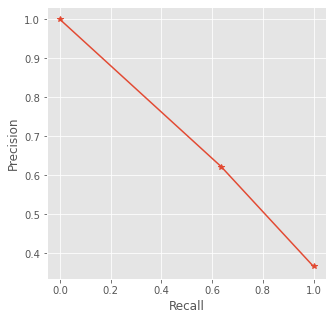

In [83]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize = (5, 5))

plt.plot(recall, precision, marker='*')
plt.xlabel('Recall')
plt.ylabel('Precision');

Confusion matrix:
 [[59 17]
 [16 28]]


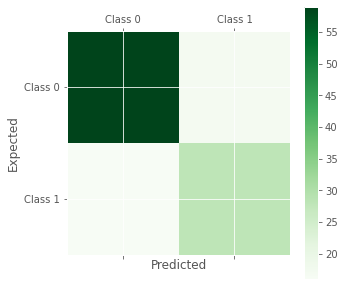

<Figure size 432x288 with 0 Axes>

In [84]:
def plot_confusion_mat(t_y, p_y, thresh):   
    # confusion matrix
    conf_mat = confusion_matrix(y_true=t_y, y_pred=p_y)
    print('Confusion matrix:\n', conf_mat)
    
    # plot matrix
    labels = ['Class 0', 'Class 1']
    fig = plt.figure(figsize=(5, 5))
    plt.style.use("ggplot")
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Greens)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    plt.savefig("Confusion matrix for threshold : {}.png".format(thresh))
plot_confusion_mat(y_true, y_pred, thresh="5")

Threshold value :  4
Weighted F1 Score : 0.6714



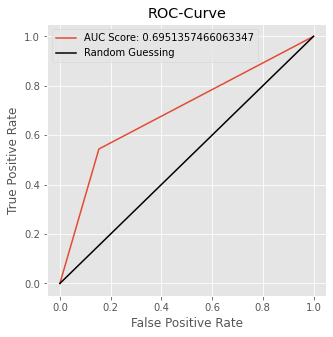

Confusion matrix:
 [[44  8]
 [31 37]]


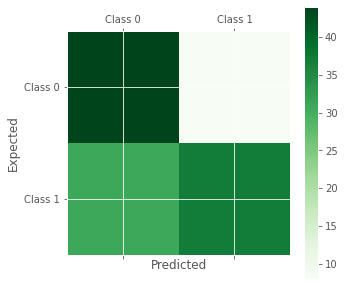

Threshold value :  5
Weighted F1 Score : 0.7256



<Figure size 432x288 with 0 Axes>

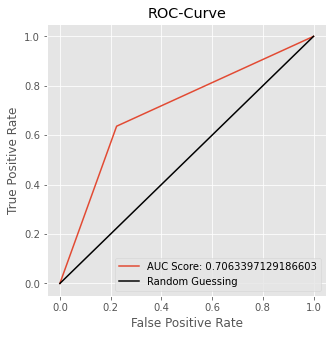

Confusion matrix:
 [[59 17]
 [16 28]]


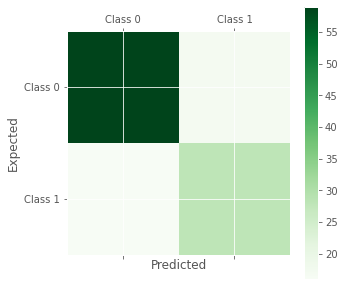

Threshold value :  6
Weighted F1 Score : 0.7624



<Figure size 432x288 with 0 Axes>

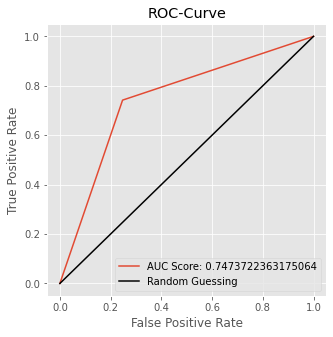

Confusion matrix:
 [[67 22]
 [ 8 23]]


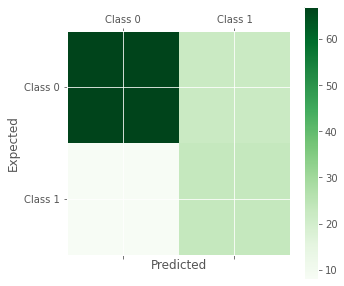

<Figure size 432x288 with 0 Axes>

In [85]:
for thresh in [4, 5, 6]:
    print("Threshold value : ", thresh)
    pred_test_dft = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'], thresh=thresh)
    y_truet = pred_test_dft['label_value'].values
    y_predt = pred_test_dft['score'].values
    print("Weighted F1 Score : {:.4f}\n".format(f1_score(y_truet, y_predt, average='weighted')))
    plot_roc_curve(y_truet, y_predt)
    plot_confusion_mat(y_truet, y_predt, thresh=thresh)


### Precision-Recall Tradeoff
- Precision is the percentage or proportion of True Positives correctly detected by the classifier. It does not take into consideration the False Negatives. Hence, it does not necessarily mean that patients not selected for testing are actually **True Negatives**
- Recall is the percentage or proportion of actual positives that were correctly detected by the classifier. Higher value provides more confidence in correctly identifying negative values. However, it ignores False Positives.

- F1-Score: Instead of trying to balance Precision and Recall, it is advisable to try to maximize the F1-Score. F1-Score is maximum when both Precision and Recall are balanced. Otherwise, it is lower than the max value. The threshold value of 6 gives the highest F1-Score

### Setting threshold to 6

Threshold value :  6
Weighted F1 Score : 0.7624



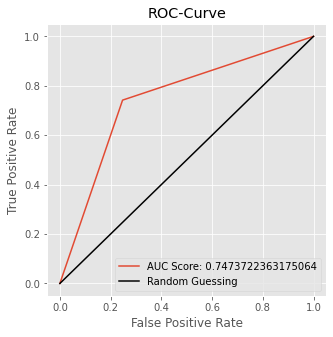

Confusion matrix:
 [[67 22]
 [ 8 23]]


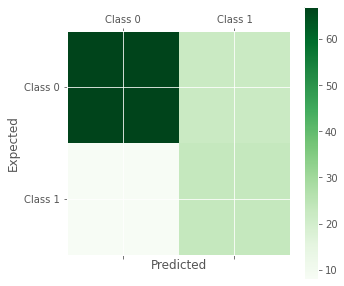

<Figure size 432x288 with 0 Axes>

In [89]:
thresh = 6
print("Threshold value : ", thresh)
pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'], thresh=thresh)
y_true = pred_test_df['label_value'].values
y_pred = pred_test_df['score'].values
print("Weighted F1 Score : {:.4f}\n".format(f1_score(y_true, y_pred, average='weighted')))
plot_roc_curve(y_true, y_pred)
plot_confusion_mat(y_true, y_pred, thresh=thresh)


#### What are some areas of improvement for future iterations?

1. Invest more time and resouces in fine tuning the model hyper-parameters 
2. Another area of improvement is the imputation of missing values. A generalized approach does not help in achieving the best results for the model.
3. The data should be more diverse, represent general population and uinformly balanced for optimum results.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [90]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)
/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


model_id, score_thresholds 1 {'rank_abs': [45]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [91]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

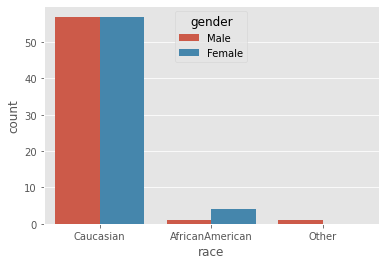

In [92]:
import seaborn as sns
plt.style.use("ggplot")
ax_pred_r = sns.countplot(x="race", hue="gender", data=ae_subset_df)

In [93]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,45,race,AfricanAmerican,2,3,1,1,2,1,2,3,5,120
1,1,binary 0/1,45,race,Caucasian,43,71,21,7,64,22,29,85,114,120
2,1,binary 0/1,45,race,Other,0,1,0,0,1,0,0,1,1,120
3,1,binary 0/1,45,gender,Female,26,35,13,5,30,13,18,43,61,120
4,1,binary 0/1,45,gender,Male,19,40,9,3,37,10,13,46,59,120


In [94]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,AfricanAmerican,0.50,0.67,0.33,0.50,0.33,0.50,0.67,0.50,0.04,0.40,0.40
1,race,Caucasian,0.76,0.75,0.10,0.49,0.25,0.24,0.90,0.51,0.96,0.38,0.25
2,race,Other,NaN,1.00,0.00,NaN,0.00,NaN,1.00,NaN,0.00,0.00,0.00
3,gender,Female,0.72,0.70,0.14,0.50,0.30,0.28,0.86,0.50,0.58,0.43,0.30
4,gender,Male,0.77,0.80,0.08,0.47,0.20,0.23,0.92,0.53,0.42,0.32,0.22


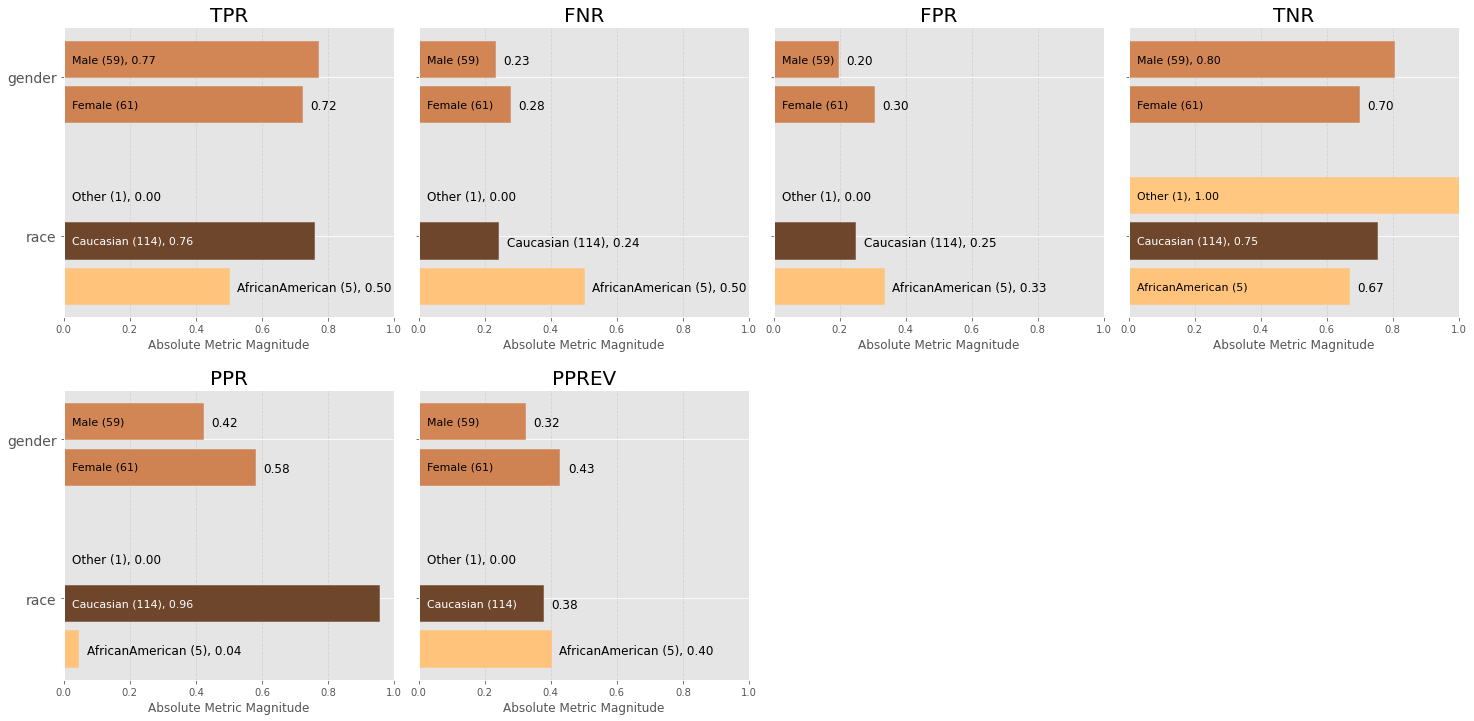

In [95]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fnr', 'fpr', 'tnr', 'ppr', 'pprev'], ncols=4)

#### Is there significant bias in your model for either race or gender?

Bias is present in both, race and gender:

1. PPR: considering race, 'Caucasian' has the highest PPR compared to other races by quite a margin. Considering gender, male has higher PPR compared to females
2. TPR: considering race, 'AfricanAmerican' has the highest TPR compared to other races by quite a margin. Considering gender, male has higher PPR compared to females. This implies that the model is likely to predict more Male patients for testing than females.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

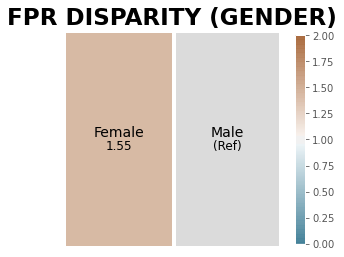

In [98]:
# Reference group fairness plot
fpr_disparity = aqp.plot_disparity(fdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

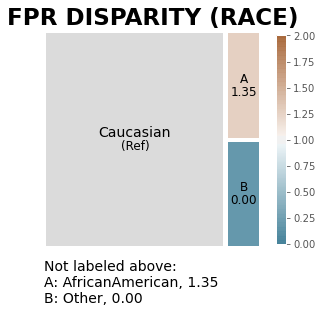

In [97]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

From FPR Displarity plots, it is easily visible that:
1. Females are 1.55 times more likely to be falsely identified as a patient for drug testing versus the reference group (Male). This suggests that there is less disparity at a gender level.
2. 'African American' 1.35 times more likely to be falsely identified as a patient for drug testing versus the reference group (Male, Causasian). Overall, the data for 'Other' and 'African American' is so under-represented in the dataset that it should be ignored from any prediction by the model.

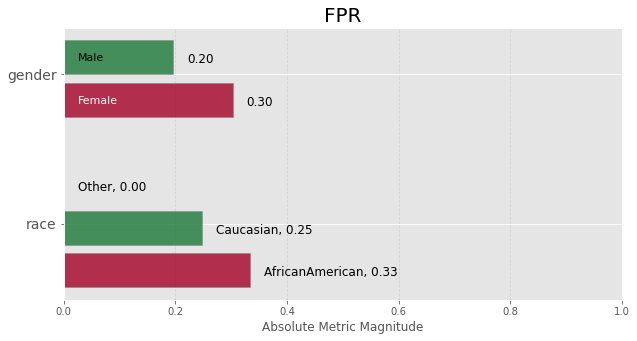

In [99]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

Absolute Value Fairness Determination:
- Red = False/Not Fair
- Green = True/Fair
The above plot also identifies the bias in race where 'African American' will be falsely identified by the model.

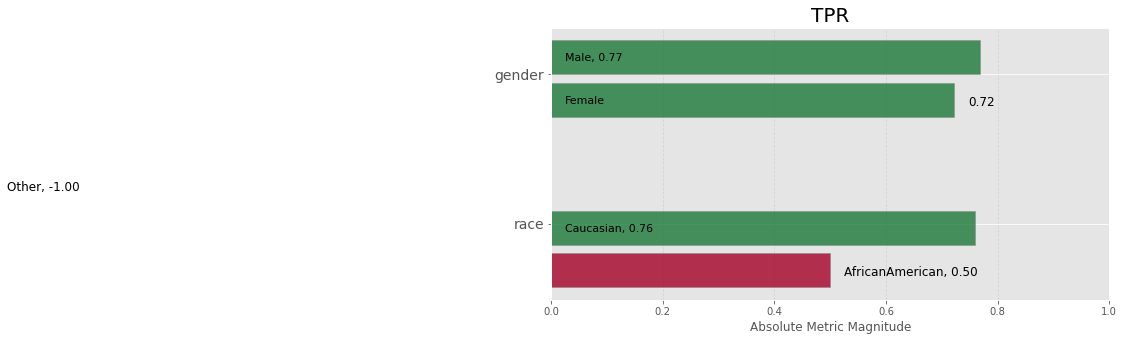

In [101]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)